In [18]:
#%pip install matplotlib
#%pip install seaborn
#%pip install scikit-learn
#%pip install imbalanced-learn
#%pip install xgboost
#%pip install lightgbm

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

#### 1. 데이터 생성

In [20]:
salary = pd.read_csv('salary.csv')

print(np.shape(salary)) # 32561행 15열

print(np.sum(salary['salary'] == '<=50K')) # 24720개
print(np.sum(salary['salary'] == '>50K')) # 7841개

(32561, 15)
24720
7841


In [21]:
# 데이터 통계량 확인
salary.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### 2. 데이터 확인 (5개)

In [22]:
salary[:5]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### 3. 변수 타입 확인

In [23]:
salary.dtypes
# int64: 수치형, object: 범주형

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

#### 4. 중복 데이터 확인 및 제거

In [24]:
print(np.sum(salary.duplicated())) # 중복 데이터 24개

salary = salary.drop_duplicates() # 중복 데이터 제거
print(np.shape(salary)) # 32537행 15열

24
(32537, 15)


#### 5. 범주형 변수의 범주 및 빈도수 확인

##### 5-1. workclass 변수

>Private(일반 회사원)  
Self-emp-not-inc(비법인 자영업자)  
Self-emp-inc(법인 자영업자)  
Federal-gov(연방정부 공무원)  
Local-gov(지방정부 공무원)  
State-gov(주립정부 공무원)  
Never-worked(일 경험 없음)  
Without-pay(무보수)  
?(결측치)  

In [25]:
print(salary['workclass'].value_counts()) # 결측치 1836개

workclass
Private             22673
Self-emp-not-inc     2540
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64


##### 5-2. education 변수

>Doctorate(박사 학위)  
Masters(석사 학위)  
Bachelors(4년제 학사)  
Some-college(전문대)  
Assoc-voc(준학사 학위)  
Assoc-acdm(아카데믹 어소시에이트)  
Prof-school(전문 학교)  
HS-grad(고졸)  
9th(9학년)  
7th-8th(7학년-8학년)  
5th-6th(5학년-6학년)  
1st-4th(1학년-4학년)  
Preschool(유치원)  

In [26]:
salary['education'].value_counts()

education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: count, dtype: int64

In [27]:
salary['education-num'].value_counts()
# 확인 결과 학력이 낮은 순서로 1, 2, ..., 16까지 라벨 인코딩 되어 있음

education-num
9     10494
10     7282
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: count, dtype: int64

##### 5-3. marital-status 변수

>Divorced(이혼)  
Married-AF-spouse(군인 배우자와 결혼)  
Married-civ-spouse(민간인 배우자와 결혼)  
Married-spouse-absent(직장 등의 이유로 별거)  
Never-married(미혼)  
Separated(이혼 등의 이유로 별거)  
Widowed(미망인)  

In [28]:
print(salary['marital-status'].value_counts())

marital-status
Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64


##### 5-4. occupation 변수

>Prof-specialty(전문직)  
Craft-repair(수리공)  
Exec-managerial(경영진)  
Adm-clerical(사무/관리직)  
Sales(판매업)  
Other-service(기타 서비스업)  
Machine-op-inspct(기계 검사 직종)  
Transport-moving(운송업)  
Handlers-cleaners(청소업)  
Farming-fishing(농/어업)  
Tech-support(기술 지원 직종)  
Protective-serv(보호 서비스업)  
Priv-house-serv(개인 주택 서비스업)  
Armed-Forces(군인)  
?(결측치)

In [29]:
print(salary['occupation'].value_counts()) # 결측치 1843개

occupation
Prof-specialty       4136
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
?                    1843
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: count, dtype: int64


##### 5-5. relationship 변수

>Husband(남편)  
Not-in-family(가족에 속하지 않음)  
Own-child(자식)  
Unmarried(미혼)  
Wife(부인)  
Other-relative(다른 관계)  

In [30]:
print(salary['relationship'].value_counts())

relationship
Husband           13187
Not-in-family      8292
Own-child          5064
Unmarried          3445
Wife               1568
Other-relative      981
Name: count, dtype: int64


##### 5-6. race 변수

>White(백인)  
Black(흑인)  
Asian-Pac-Islander(아시아인/태평양 섬 주민)  
Amer-Indian-Eskimo(아메리카 원주민/에스키모)  
Other(다른 인종)  

In [31]:
print(salary['race'].value_counts())

race
White                 27795
Black                  3122
Asian-Pac-Islander     1038
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64


##### 5-7. sex 변수

>Male(남)  
Female(여)  

In [32]:
print(salary['sex'].value_counts())

sex
Male      21775
Female    10762
Name: count, dtype: int64


##### 5-8. native-country 변수

In [33]:
print(salary['native-country'].value_counts()) # 결측치 582개

native-country
United-States                 29153
Mexico                          639
?                               582
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Japan                            62
Guatemala                        62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France       

##### 5-9. salary 변수 

In [34]:
print(salary['salary'].value_counts())

salary
<=50K    24698
>50K      7839
Name: count, dtype: int64


#### 6. 수치형 변수의 이상치 확인

##### 6-1. age 변수

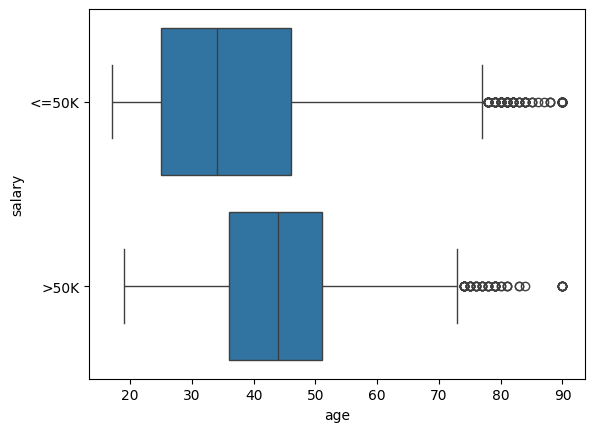

In [35]:
sns.boxplot(x = 'age', y = 'salary', data = salary)
plt.rcParams['figure.figsize'] = [15, 2] # [width, height] (inches)
plt.show()

##### 6-2. fnlwgt 변수

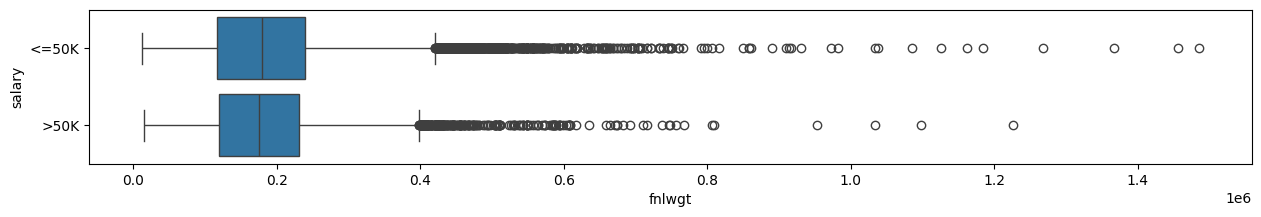

In [36]:
sns.boxplot(x = 'fnlwgt', y = 'salary', data = salary)
plt.show()

##### 6-3. education-num 변수

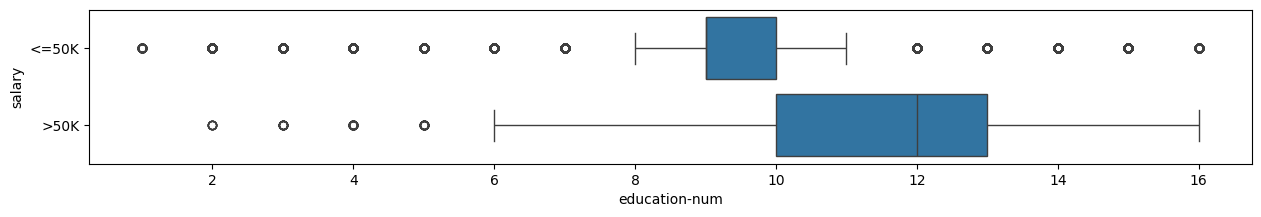

In [37]:
sns.boxplot(x = 'education-num', y = 'salary', data = salary)
plt.show()

##### 6-4. capital-gain 변수

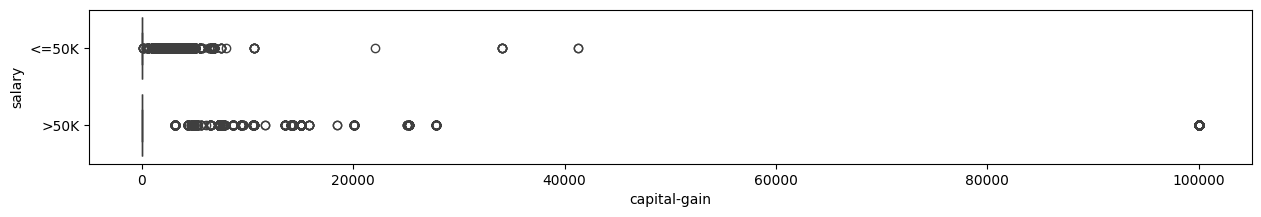

In [38]:
sns.boxplot(x = 'capital-gain', y = 'salary', data = salary)
plt.show()

##### 6-5. capital-loss 변수

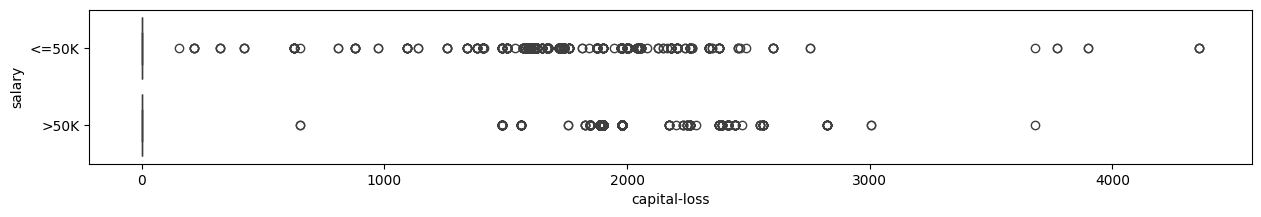

In [39]:
sns.boxplot(x = 'capital-loss', y = 'salary', data = salary)
plt.show()

##### 6-6. hours-per-week 변수

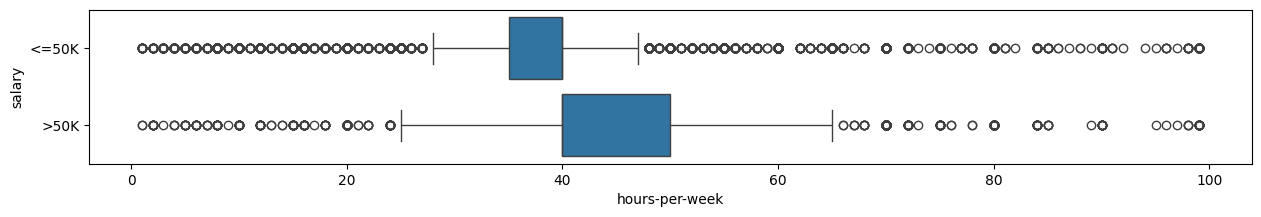

In [40]:
sns.boxplot(x = 'hours-per-week', y = 'salary', data = salary)
plt.show()

>비록 수치형 변수들의 이상치가 많지만 이 데이터들은 실제 값이며  
이상치를 모두 제거한다면 손실이 크기 때문에 데이터 분석의 신뢰성을 잃을 수도 있어  
이상치를 제거하지 않기로 결정

#### 7. 데이터 전처리

##### 7-1. workclass 변수

>workclass 변수의 경우 범주가 너무 많고 Private의 비율이 크기 때문에 Self-emp-not-inc과 Self-emp-inc를 Self-emp(자영업자)로 통합하고 Federal-gov, Local-gov, State-gov를 gov(공무원)로 통합했다. 또한, Never-worked, Without-pay, 결측치를 other(그 외)로 통합하여 4개의 범주로 줄였다.

In [41]:
def integrate_workclass(category):
    if category in ['Self-emp-not-inc', 'Self-emp-inc']:
        return 'Self-emp'
    elif category in ['Federal-gov', 'Local-gov', 'State-gov']:
        return 'gov'
    elif category in ['Never-worked', 'Without-pay', '?']:
        return 'other'
    else:
        return category
    
salary['workclass2'] = salary['workclass'].apply(integrate_workclass)
print(salary['workclass2'].value_counts())

workclass2
Private     22673
gov          4351
Self-emp     3656
other        1857
Name: count, dtype: int64


##### 7-2. native-country 변수

>native-country 변수의 경우 United-States을 제외한 나머지 국가들의 도수가 너무 적어 United-States를 제외한 나머지 변수들과 결측치를 other(그 외)로 통합하여 총 2개의 범주로 줄였다.

In [42]:
def integrate_country(category):
    if category not in 'United-States':
        return 'other'
    else:
        return category

salary['native-country2'] = salary['native-country'].apply(integrate_country)
print(salary['native-country2'].value_counts())

native-country2
United-States    29153
other             3384
Name: count, dtype: int64


##### 7-3. marital-status 변수

>marital-status 변수의 경우 Married-AF-spouse, Married-spouse-absent, Separated, Widowed를 미혼은 아니지만 어떠한 이유에서든 배우자와 동거하지 않은 상태라고 취급하여 other(그 외)로 통합하여 총 4개의 범주로 줄였다.

In [43]:
def integrate_marital(category):
    if category in ['Married-AF-spouse', 'Married-spouse-absent', 'Separated', 'Widowed']:
        return 'other'
    else:
        return category

salary['marital-status2'] = salary['marital-status'].apply(integrate_marital)
print(salary['marital-status2'].value_counts())

marital-status2
Married-civ-spouse    14970
Never-married         10667
Divorced               4441
other                  2459
Name: count, dtype: int64


##### 7-4. capital 변수

>capital 변수의 경우 capital-gain과 capital-loss의 두 변수로 나뉘었지만, capital-gain은 자본을 얻은 양, capital-loss는 자본을 잃은 양을 나타내서 자본을 얻음과 동시에 잃는 것은 불가능하므로 두 변수의 수치가 동시에 0을 초과하는 경우는 없었으며 capital-loss의 값들을 음수로 취한 뒤 capital-gain 변수와 합쳐주어 capital이라는 하나의 변수로 통합시켰다.

In [44]:
# 두 변수의 수치가 동시에 0을 초과하는 경우의 개수
np.sum( (salary['capital-gain'] > 0) * (salary['capital-loss'] > 0) )

0

In [45]:
salary['capital'] = salary['capital-gain'] - salary['capital-loss']

#### 8. 변수 제거

>relationship 변수와 occupation 변수를 제거했다. 왜냐하면, relationship 변수에 속한 범주의 의미를 명확하게 파악하기 어려웠으며 marital-status 변수로도 relationship을 충분히 설명할 수 있다고 생각했기 때문이며 occupation 변수의 경우 범주가 너무 많고 workclass 변수가 상위 개념이라고 생각되어 occupation 변수를 충분히 설명할 수 있다고 생각하여 두 변수를 제거했다.

In [46]:
salary2 = salary.drop(columns = ['relationship', 'occupation'])

print(salary2.columns) # relationship, occupation 변수 제거됨

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'salary', 'workclass2',
       'native-country2', 'marital-status2', 'capital'],
      dtype='object')


#### 9. 인코딩

>salary는 ‘>50K’을 1로, ‘<=50K’을 0으로, sex 변수는 Female을 0, Male을 1로, native-country 변수는 United-States를 0, other를 1로 변환시켰다.

>workclass, marital-status, race 변수는 Label Encoding을 해주었다.

##### 9-1. salary 변수

In [47]:
def salary_encoder(category):
    if category == '<=50K':
        return 0
    else:
        return 1
    
salary2['salary_encoded'] = salary2['salary'].apply(salary_encoder)
print(salary2[['salary', 'salary_encoded']])

      salary  salary_encoded
0      <=50K               0
1      <=50K               0
2      <=50K               0
3      <=50K               0
4      <=50K               0
...      ...             ...
32556  <=50K               0
32557   >50K               1
32558  <=50K               0
32559  <=50K               0
32560   >50K               1

[32537 rows x 2 columns]


##### 9-2. sex 변수

In [48]:
def sex_encoder(category):
    if category == 'Male':
        return 0
    else:
        return 1
    
salary2['sex_encoded'] = salary2['sex'].apply(sex_encoder)
print(salary2[['sex', 'sex_encoded']])

          sex  sex_encoded
0        Male            0
1        Male            0
2        Male            0
3        Male            0
4      Female            1
...       ...          ...
32556  Female            1
32557    Male            0
32558  Female            1
32559    Male            0
32560  Female            1

[32537 rows x 2 columns]


##### 9-3. native-country 변수

In [49]:
def country_encoder(category):
    if category == 'United-States':
        return 0
    else:
        return 1
    
salary2['country_encoded'] = salary2['native-country'].apply(country_encoder)
print(salary2[['native-country', 'country_encoded']])

      native-country  country_encoded
0      United-States                0
1      United-States                0
2      United-States                0
3      United-States                0
4               Cuba                1
...              ...              ...
32556  United-States                0
32557  United-States                0
32558  United-States                0
32559  United-States                0
32560  United-States                0

[32537 rows x 2 columns]


##### 9-4. workclass 변수

In [50]:
label_encoder = LabelEncoder()

salary2['workclass_encoded'] = label_encoder.fit_transform(salary2['workclass2'])
print(salary2[['workclass2', 'workclass_encoded']])

print("Classes:", label_encoder.classes_)
# Private: 0, Self-emp: 1, gov: 2, other: 3

      workclass2  workclass_encoded
0            gov                  2
1       Self-emp                  1
2        Private                  0
3        Private                  0
4        Private                  0
...          ...                ...
32556    Private                  0
32557    Private                  0
32558    Private                  0
32559    Private                  0
32560   Self-emp                  1

[32537 rows x 2 columns]
Classes: ['Private' 'Self-emp' 'gov' 'other']


##### 9-5. marital-status 변수

In [51]:
label_encoder = LabelEncoder()

salary2['marital_encoded'] = label_encoder.fit_transform(salary2['marital-status2'])
print(salary2[['marital-status2', 'marital_encoded']])

print("Classes:", label_encoder.classes_)
# Divorced: 0, Married-civ-spouse: 1, Never-married: 2, other: 3

          marital-status2  marital_encoded
0           Never-married                2
1      Married-civ-spouse                1
2                Divorced                0
3      Married-civ-spouse                1
4      Married-civ-spouse                1
...                   ...              ...
32556  Married-civ-spouse                1
32557  Married-civ-spouse                1
32558               other                3
32559       Never-married                2
32560  Married-civ-spouse                1

[32537 rows x 2 columns]
Classes: ['Divorced' 'Married-civ-spouse' 'Never-married' 'other']


##### 9-6. race 변수

In [52]:
label_encoder = LabelEncoder()

salary2['race_encoded'] = label_encoder.fit_transform(salary2['race'])
print(salary2[['race', 'race_encoded']])

print("Classes:", label_encoder.classes_)
# Amer-Indian-Eskimo: 0, Asian-Pac-Islander: 1, Black: 2, Other: 3, White: 4

        race  race_encoded
0      White             4
1      White             4
2      White             4
3      Black             2
4      Black             2
...      ...           ...
32556  White             4
32557  White             4
32558  White             4
32559  White             4
32560  White             4

[32537 rows x 2 columns]
Classes: ['Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Black' 'Other' 'White']


#### 10. 최종 데이터프레임

In [53]:
print(salary2.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'salary', 'workclass2',
       'native-country2', 'marital-status2', 'capital', 'salary_encoded',
       'sex_encoded', 'country_encoded', 'workclass_encoded',
       'marital_encoded', 'race_encoded'],
      dtype='object')


In [54]:
salary3 = salary2[['age','workclass_encoded','fnlwgt','education-num','marital_encoded', 'race_encoded',
              'sex_encoded', 'capital', 'hours-per-week', 'country_encoded', 'salary_encoded']]

df = salary3.rename(columns = {'workclass_encoded': 'workclass', 'marital_encoded': 'marital-status',
                     'race_encoded': 'race', 'sex_encoded': 'sex', 'country_encoded': 'native-country',
                     'salary_encoded': 'salary'})

In [55]:
df

,age,workclass,fnlwgt,education-num,marital-status,race,sex,capital,hours-per-week,native-country,salary
0,39,2,77516,13,2,4,0,2174,40,0,0
1,50,1,83311,13,1,4,0,0,13,0,0
2,38,0,215646,9,0,4,0,0,40,0,0
3,53,0,234721,7,1,2,0,0,40,0,0
4,28,0,338409,13,1,2,1,0,40,1,0
...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,257302,12,1,4,1,0,38,0,0
32557,40,0,154374,9,1,4,0,0,40,0,1
32558,58,0,151910,9,3,4,1,0,40,0,0
32559,22,0,201490,9,2,4,0,0,20,0,0


#### 11. 데이터 분할

>해당 데이터는 종속변수인 salary의 0이 24698개, 1이 7839개로 불균형이 심하다. 데이터 클래스 비율이 너무 차이가 나면(highly-imbalanced data) 단순히 우세한 클래스를 택하는 모형의 정확도가 높아지므로 모형의 성능판별이 어려워진다. 즉, 정확도(accuracy)가 높아도 데이터 개수가 적은 클래스의 재현율(recall-rate)이 급격히 줄어드는 현상이 발생할 수 있다. 따라서 샘플링을 진행하기로 결정

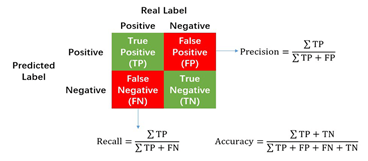

In [56]:
print('salary = 0 :', np.sum(df['salary'] == 0), '개')
print('salary = 1 :', np.sum(df['salary'] == 1), '개')

salary = 0 : 24698 개
salary = 1 : 7839 개


##### 12. 데이터 샘플링 (SMOTE-Tomek sampling)

>샘플링의 종류에는 다수 클래스 데이터에서 일부만 사용하는 Undersampling, 소수 클래스 데이터를 증가시키는 Oversampling, 복합 샘플링이 있다. 본 프로젝트에서는 복합 샘플링을 사용하기로 결정했으며 복합 샘플링 방법중 하나인 SMOTE-Tomek을 사용했다. SMOTE-Tomek은 Oversampling과 Undersampling을 함께 수행하는 방법으로, 이름 그대로 SMOTE로 Oversampling을, Tomek Links로 Undersampling을 수행한다. sampling을 해주기 전에 데이터를 학습용 데이터 셋으로 70%, 나머지 30%는 검증용 데이터 셋으로 나누어 주었다.

In [57]:
# 특성 데이터(x)와 반응변수(y) 설정
x = df.drop(columns = ['salary']) # 반응변수를 제외한 설명변수
y = df['salary'] # 반응변수

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

print(np.shape(y_train)) # train 22775개
print(np.shape(y_test)) # test 9762개

(22775,)
(9762,)


>샘플링은 학습용 데이터 셋에만 해줘야 하므로 학습용 데이터 셋에 SMOTE-Tomek sampling을 해주었다.

In [58]:
# SMOTE-Tomek 샘플링 적용
smt = SMOTETomek(random_state = 42)
x_train_resampled, y_train_resampled = smt.fit_resample(x_train, y_train)

# 샘플링 결과 확인
print(np.shape(y_train_resampled)) # train set이 22775에서 30596으로 증가

(30596,)


>샘플링 후에는 0과 1 모두 15298개로 비율이 맞춰진 것을 확인했다.

In [45]:
print('샘플링 전 0과 1의 개수')
print('0:', np.sum(y_train == 0))
print('1:', np.sum(y_train == 1))
print('샘플링 후 0과 1의 개수')
print('0:', np.sum(y_train_resampled == 0))
print('1:', np.sum(y_train_resampled == 1))

샘플링 전 0과 1의 개수
0: 17293
1: 5482
샘플링 후 0과 1의 개수
0: 15298
1: 15298


#### 13. 데이터 분석

##### 13-1. DecisionTree

>의사결정나무(Decision Tree)는 Machine Learning의 지도 학습(Supervised Learning)에 해당하는 알고리즘으로써 의사결정 규칙을 나무구조로 도표화하여 분류와 예측을 수행한다. 의사결정나무는 직관적으로 이해하기 쉽고 설명할 때 사용하기 용이하다. 하지만, 과적합 및 과소적합이 발생하기 쉬우므로 사용할 때 각별한 주의가 필요하며, 트리의 규모가 클수록 이해하기가 어려워지는 단점이 존재한다. 트리 모델의 경우, 불순도 및 엔트로피 등을 활용하여 분류를 진행하기 때문에 수치형 데이터에 대한 스케일링 과정을 거치지 않아도 된다.

13-1-1. 기본 모델로 학습

In [69]:
# 결정트리 모델 생성
dt = DecisionTreeClassifier(random_state = 42)

# 모델 학습
dt.fit(x_train_resampled, y_train_resampled)

# 예측
y_pred = dt.predict(x_test) # 예측된 y (x_test를 DecisionTree 모델에 넣어서 y값을 예측)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('정확도:', accuracy) # 실제 데이터를 약 78% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_pred))

정확도: 0.7816021307109199


              precision    recall  f1-score   support

           0       0.89      0.81      0.85      7405
           1       0.54      0.68      0.60      2357

    accuracy                           0.78      9762
   macro avg       0.71      0.75      0.72      9762
weighted avg       0.80      0.78      0.79      9762



13-1-2. 하이퍼 파라미터 튜닝으로 학습 (GridSearchCV)

>max_depth: 트리의 최대 깊이 지정  
min_samples_split: 노드를 분할하기 위한 최소 샘플 수 지정  
min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수 지정  
max_features: 각 노드에서 분할에 사용할 특성의 최대 수 지정  
criterion: 노드에서의 분할 기준 선택 (기본값은 'gini'이며, 'entropy'도 사용 가능)  

In [67]:
# 탐색할 하이퍼 파라미터 그리드 설정
param_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

> estimator: 검색 대상 모델  
param_grid: 탐색할 하이퍼 파라미터 그리드  
cv: 교차 검증을 위한 폴드(fold)의 수  
n_jobs: 병렬 처리를 위한 작업 수 (-1은 가능한 모든 프로세서 사용)  
scoring: 성능 측정 지표  

In [70]:
# GridSearchCV 객체 생성
dt_grid_search = GridSearchCV(estimator = dt, param_grid = param_dt,
                              cv = 5, n_jobs = -1, scoring = 'accuracy')

# 그리드 탐색 수행
dt_grid_search.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [71]:
# 최적의 파라미터와 점수 출력
print('최적의 파라미터')
print(dt_grid_search.best_params_)
print('\n정확도:', dt_grid_search.best_score_) # validation set을 약 83% 맞춤

최적의 파라미터
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}

정확도: 0.8312858427676785


In [72]:
# 예측
y_dt_grid_pred = dt_grid_search.predict(x_test)

# 정확도 평가
dt_grid_accuracy = accuracy_score(y_test, y_dt_grid_pred)
print('정확도:', dt_grid_accuracy) # 실제 데이터를 약 77% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_dt_grid_pred))

정확도: 0.7724851464863758


              precision    recall  f1-score   support

           0       0.94      0.75      0.83      7405
           1       0.52      0.84      0.64      2357

    accuracy                           0.77      9762
   macro avg       0.73      0.79      0.74      9762
weighted avg       0.83      0.77      0.79      9762



In [73]:
# 결정 트리 모델에서 변수 중요도 추출 (% 단위)
dt_importances = dt_grid_search.best_estimator_.feature_importances_
dt_percent_importances = np.round(dt_importances, 3) * 100

print(dt_percent_importances)

# 변수 이름과 중요도 출력
feature_names = ['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
                 'race', 'sex', 'capital', 'hours-per-week', 'native-country']

for feature_name, importance in zip(feature_names, dt_percent_importances):
    print(feature_name, ':', np.round(importance, 1), '%')

[ 7.4  0.3  0.  17.4 59.9  0.   4.7  6.7  2.8  0.8]
age : 7.4 %
workclass : 0.3 %
fnlwgt : 0.0 %
education-num : 17.4 %
marital-status : 59.9 %
race : 0.0 %
sex : 4.7 %
capital : 6.7 %
hours-per-week : 2.8 %
native-country : 0.8 %


In [74]:
# 변수 중요도 내림차순
a = pd.DataFrame({'Feature' : feature_names, 'Importance' : dt_percent_importances})
a.sort_values(by = 'Importance', ascending=False)

,Feature,Importance
4,marital-status,59.9
3,education-num,17.4
0,age,7.4
7,capital,6.7
6,sex,4.7
8,hours-per-week,2.8
9,native-country,0.8
1,workclass,0.3
2,fnlwgt,0.0
5,race,0.0


##### 13-2. XGBoost

>XGBoost는 Extreme Gradient Boosting의 약자이다. 먼저, Boosting은 여러 개의 약한 Decision Tree를 조합해서 사용하는 Ensemble 기법 중 하나이다. 즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측 모형을 만든다. Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost가 대표적인데 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost이다. XGBoost의 장점은 GBM 대비 빠른 수행시간이다. 병렬 처리로 학습하고 분류 속도 빠르다. 또한, 자체의 과적합 규제 기능으로 강한 내구성을 지닌다.

13-2-1. 기본 모델로 학습

In [52]:
# 결정트리 모델 생성
xgb = XGBClassifier(random_state = 42)

# 모델 학습
xgb.fit(x_train_resampled, y_train_resampled)

# 예측
y_pred = xgb.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('정확도:', accuracy) # 실제 데이터를 약 82% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_pred))

정확도: 0.8219627125589019


              precision    recall  f1-score   support

           0       0.92      0.84      0.88      7405
           1       0.60      0.76      0.67      2357

    accuracy                           0.82      9762
   macro avg       0.76      0.80      0.78      9762
weighted avg       0.84      0.82      0.83      9762



13-2-2. 하이퍼 파라미터 튜닝으로 학습 (GridSearchCV)

>n_estimators: 트리의 개수 지정 (기본값 100)  
learning_rate: 학습률 (학습률이 작을수록 모델이 더 안정적으로 수렴하고 더 많은 트리가 필요)  
max_depth: 트리의 최대 깊이 지정  
sub_sample: 각 트리를 학습하는 데 사용되는 훈련 데이터의 일부분의 비율  
min_child_weight: 각 내부 노드에서의 최소 가중치 합을 나타내는 파라미터  

In [53]:
# 탐색할 하이퍼 파라미터 그리드 설정
param_xgb = {
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [0.001, 0.01, 0.1],
    'max_depth' : [3, 5, 7],
    'subsample' : [0.5, 0.7, 0.9],
    'min_child_weight' : [1, 3, 5]
}

In [54]:
# GridSearchCV 객체 생성
xgb_grid_search = GridSearchCV(estimator = xgb, param_grid = param_xgb,
                               cv = 5, n_jobs = -1, scoring = 'accuracy')

# 그리드 탐색 수행
xgb_grid_search.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.5, 0.7, 0.9]},
             scoring='accuracy')

In [55]:
# 최적의 파라미터와 점수 출력
print('최적의 파라미터')
print(xgb_grid_search.best_params_)
print(xgb_grid_search.best_score_)

최적의 파라미터
{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.9}
0.8741687628911128


In [56]:
# 예측
y_xgb_grid_pred = xgb_grid_search.predict(x_test)

# 정확도 평가
xgb_grid_accuracy = accuracy_score(y_test, y_xgb_grid_pred)
print('정확도:', xgb_grid_accuracy) # 실제 데이터를 약 82% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_xgb_grid_pred))

정확도: 0.8247285392337635


              precision    recall  f1-score   support

           0       0.92      0.84      0.88      7405
           1       0.61      0.77      0.68      2357

    accuracy                           0.82      9762
   macro avg       0.76      0.80      0.78      9762
weighted avg       0.84      0.82      0.83      9762



In [102]:
# XGBoost 모델에서 변수 중요도 추출 (%단위)
xgb_importances = xgb_grid_search.best_estimator_.feature_importances_
xgb_percent_importances = np.round(xgb_importances, 3) * 100

print(xgb_percent_importances)

# 변수 이름과 중요도 출력
for feature_name, importance in zip(feature_names, xgb_percent_importances):
    print(feature_name,':' , np.round(importance, 1), '%')

[ 3.1        2.4        1.3000001  7.5000005 49.7        2.4
 13.7        8.7        4.4        6.8      ]
age : 3.1 %
workclass : 2.4 %
fnlwgt : 1.3 %
education-num : 7.5 %
marital-status : 49.7 %
race : 2.4 %
sex : 13.7 %
capital : 8.7 %
hours-per-week : 4.4 %
native-country : 6.8 %


In [103]:
# 변수 중요도 내림차순
a = pd.DataFrame({'Feature' : feature_names, 'Importance' : xgb_percent_importances})
a.sort_values(by = 'Importance', ascending=False)

,Feature,Importance
4,marital-status,49.700001
6,sex,13.700000
7,capital,8.700000
3,education-num,7.500000
9,native-country,6.800000
8,hours-per-week,4.400000
0,age,3.100000
1,workclass,2.400000
5,race,2.400000
2,fnlwgt,1.300000


##### 13-3. GradientBoosting

>GradientBoosting은 앙상블(ensemble) 기법 중 부스팅(Boosting) 계열에 속하는 알고리즘으로 엑셀형 데이터에 대한 예측에서 엄청난 성능을 보여주고 있으며 머신러닝 알고리즘 중에서도 가장 예측 성능이 높다고 알려진 알고리즘이다. 부스팅(Boosting)이란 가중치를 반영한 약한 분류기를 결합하여 강한 분류기를 만드는 과정이다. GradientBoosting은 얕은 Tree를 많이 연결하는 과정에서 이전 Tree의 오차를 보완하는 방식으로 순차적으로 Tree를 만든다. 각각의 얕은 Tree는 데이터의 일부에 대해서만 높은 예측을 보이며 Tree가 많이 추가될수록 전체적으로 높은 성능을 보인다. 최근 각광받고 있는 XGBoost, LightGBM과 같은 파이썬 라이브러리들이 모두 GradientBoosting 알고리즘을 구현한 것들이다.

13-3-1. 기본 모델로 학습

In [58]:
# GradientBoosting 모델 생성
gb = GradientBoostingClassifier()

# 모델 학습
gb.fit(x_train_resampled, y_train_resampled)

# 예측
y_pred = gb.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('정확도:', accuracy) # 실제 데이터를 약 81% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_pred))

정확도: 0.8128457283343578


              precision    recall  f1-score   support

           0       0.93      0.82      0.87      7405
           1       0.58      0.80      0.67      2357

    accuracy                           0.81      9762
   macro avg       0.75      0.81      0.77      9762
weighted avg       0.84      0.81      0.82      9762



13-3-2. 하이퍼 파라미터 튜닝으로 학습 (GridSearchCV)

>n_estimators: 트리의 개수 지정 (기본값 100)  
learning_rate: 학습률 (학습률이 작을수록 모델이 더 안정적으로 수렴하고 더 많은 트리가 필요)  
max_depth: 트리의 최대 깊이 지정  
min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수 지정  

In [60]:
# 탐색할 하이퍼 파라미터 그리드 설정
param_gb = {
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [0.01, 0.1, 0.3],
    'max_depth' : [4, 5, 6],
    'min_samples_leaf' : [1, 2, 3],
}

In [61]:
# GridSearchCV 객체 생성
gb_grid_search = GridSearchCV(estimator = gb, param_grid = param_gb,
                              cv = 5, n_jobs = -1, scoring = 'accuracy')

# 그리드 탐색 수행
gb_grid_search.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [4, 5, 6], 'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [62]:
# 최적의 파라미터와 점수 출력
print('최적의 파라미터')
print(gb_grid_search.best_params_)
print(gb_grid_search.best_score_)

최적의 파라미터
{'learning_rate': 0.3, 'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 150}
0.886752165920571


In [66]:
# 예측
y_gb_grid_pred = gb_grid_search.predict(x_test)

# 정확도 평가
gb_grid_accuracy = accuracy_score(y_test, y_gb_grid_pred)
print('정확도:', gb_grid_accuracy) # 실제 데이터를 약 83% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_gb_grid_pred))

정확도: 0.8331284572833436


              precision    recall  f1-score   support

           0       0.91      0.86      0.89      7405
           1       0.63      0.74      0.68      2357

    accuracy                           0.83      9762
   macro avg       0.77      0.80      0.78      9762
weighted avg       0.85      0.83      0.84      9762



In [97]:
# GradientBoosting 모델에서 변수 중요도 추출 (%단위)
gb_importances = gb_grid_search.best_estimator_.feature_importances_
gb_percent_importances = np.round(gb_importances, 3) * 100

print(gb_percent_importances)

# 변수 이름과 중요도 출력
for feature_name, importance in zip(feature_names, gb_percent_importances):
    print(feature_name, ':', np.round(importance, 1), '%')

[ 7.4  1.4  7.6 13.  39.9  0.6  6.  13.6  9.3  1.1]
age : 7.4 %
workclass : 1.4 %
fnlwgt : 7.6 %
education-num : 13.0 %
marital-status : 39.9 %
race : 0.6 %
sex : 6.0 %
capital : 13.6 %
hours-per-week : 9.3 %
native-country : 1.1 %


In [98]:
# 변수 중요도 내림차순
a = pd.DataFrame({'Feature' : feature_names, 'Importance' : gb_percent_importances})
a.sort_values(by = 'Importance', ascending=False)

,Feature,Importance
4,marital-status,39.9
7,capital,13.6
3,education-num,13.0
8,hours-per-week,9.3
2,fnlwgt,7.6
0,age,7.4
6,sex,6.0
1,workclass,1.4
9,native-country,1.1
5,race,0.6


##### 13-4. RandomForest

>현재의 랜덤 포레스트의 개념은 레오 브레이먼(Leo Breiman)의 논문에서 만들어졌다. 이 논문은 랜덤 노드 최적화(randomized node optimization, RNO)와 배깅(bootstrap aggregating, bagging)을 결합한 방법과 같은 CART(classification and regression tree)를 사용해 상관관계가 없는 트리들로 포레스트를 구성하는 방법을 제시했다. 일반적으로 결정 트리를 이용한 방법의 경우, 그 결과 또는 성능의 변동 폭이 크다는 결점을 가지고 있다. 특히 학습 데이터에 따라 생성되는 결정 트리가 랜덤성에 따라 매우 다르기 때문에 일반화하여 사용하기에 어려움이 따른다. 특히, 결정 트리는 계층적 접근방식이기 때문에 만약 중간에 에러가 발생한다면 다음 단계로 에러가 계속 전파되는 특성을 가진다. 배깅(Bagging) 또는 랜덤 노드 최적화(Randomized node optimization)와 같은 랜덤화 기술은 결정 트리가 가진 이러한 단점을 극복하고 좋은 일반화 성능을 갖도록 한다.

13-4-1. 기본 모델로 학습

In [74]:
# RandomForest 모델 생성
rf = RandomForestClassifier()

#모델 학습
rf.fit(x_train_resampled, y_train_resampled)

# 예측
y_pred = rf.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('정확도:', accuracy) # 실제 데이터를 약 81% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_pred))

정확도: 0.8190944478590453


              precision    recall  f1-score   support

           0       0.91      0.84      0.88      7405
           1       0.60      0.74      0.66      2357

    accuracy                           0.82      9762
   macro avg       0.76      0.79      0.77      9762
weighted avg       0.84      0.82      0.83      9762



13-4-2. 하이퍼 파라미터 튜닝으로 학습 (GridSearchCV)

>n_estimators: 트리의 개수 지정 (기본값 100)  
max_depth: 트리의 최대 깊이 지정  
min_samples_split: 노드를 분할하기 위한 최소 샘플 수 지정  
min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수 지정 

In [76]:
# 탐색할 하이퍼 파라미터 그리드 설정
param_rf = {
    'n_estimators' : [50, 100, 150],
    'max_depth' : [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 3],
}

In [78]:
# RandomForest 객체 생성
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_rf,
                              cv = 5, n_jobs = -1, scoring = 'accuracy')

# 그리드 탐색 수행
rf_grid_search.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [81]:
# 최적의 파라미터 점수 출력
print('최적의 파라미터')
print(rf_grid_search.best_params_)
print('\n정확도:', rf_grid_search.best_score_)

최적의 파라미터
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

정확도: 0.8523676280993412


In [84]:
# 예측
y_rf_grid_pred = rf_grid_search.predict(x_test)

#정확도 평가
rf_grid_accuracy = accuracy_score(y_test, y_rf_grid_pred)
print('정확도:', rf_grid_accuracy) # 실제 데이터를 약 78% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_rf_grid_pred))

정확도: 0.7833435771358328


              precision    recall  f1-score   support

           0       0.93      0.77      0.84      7405
           1       0.53      0.83      0.65      2357

    accuracy                           0.78      9762
   macro avg       0.73      0.80      0.75      9762
weighted avg       0.84      0.78      0.80      9762



In [86]:
# RandomForest 모델에서 변수 중요도 추출 (%단위)
rf_importances = rf_grid_search.best_estimator_.feature_importances_
rf_percent_importances = np.round(rf_importances, 3) * 100

print(dt_percent_importances)

# 변수 이름과 중요도 출력
for feature_name, importance in zip(feature_names, rf_percent_importances):
    print(feature_name, ':', np.round(importance, 1), '%')

[ 7.4  0.3  0.  17.4 59.9  0.   4.7  6.7  2.8  0.8]
age : 14.2 %
workclass : 1.2 %
fnlwgt : 0.4 %
education-num : 13.7 %
marital-status : 33.2 %
race : 0.1 %
sex : 14.6 %
capital : 10.2 %
hours-per-week : 11.3 %
native-country : 1.1 %


In [93]:
# 변수 중요도 내림차순
a = pd.DataFrame({'Feature' : feature_names, 'Importance' : rf_percent_importances})
a.sort_values(by = 'Importance', ascending=False)

,Feature,Importance
4,marital-status,33.2
6,sex,14.6
0,age,14.2
3,education-num,13.7
8,hours-per-week,11.3
7,capital,10.2
1,workclass,1.2
9,native-country,1.1
2,fnlwgt,0.4
5,race,0.1


##### 13-5. LightGBM

>LightGBM은 앙상블(ensemble) 기법 중 부스팅(Boosting) 계열에 속하는 알고리즘이다. GradientBoosting과 XGBoost와 같은 기존의 Tree 기반 알고리즘들은 Tree를 수평적(level-wise)으로 분할하는 반면에 LightGBM은 Tree를 수직적(leaf-wise)으로 분할한다. Tree를 수평적으로 분할할 경우 과적합을 방지하고 균형 잡힌 Tree를 생성할 수 있다는 장점이 있지만, 균형을 맞추기 위한 시간이 오래 걸린다는 단점이 있다. 이에 반해 LightGBM은 가볍다(Light)는 특징이 있으며 Tree의 균형을 맞추지 않고 최대 손실 값을 가지는 노드를 확장하기 때문에 빠르게 분할이 가능하며 Tree가 깊어지고 비대칭적인 Tree가 생성된다. 결과적으로 수평적인 확장보다 손실값이 높은 노드에 대해 더 깊게 Tree를 분할하며 손실값을 줄일 수 있으므로 다른 부스팅 계열 알고리즘보다 더 좋은 정확도를 내거나 비슷한 수준의 성능을 내는 것으로 알려져 있다. 하지만 수직적 분할 방법은 복잡도가 증가하고 과적합 문제가 발생할 수 있으므로 작은 사이즈의 데이터에 사용하는 것은 적합하지 않다.

13-5-1. 기본 모델로 학습

In [59]:
# LightGBM 모델 생성
lgbm = lgb.LGBMClassifier()

#모델 학습
lgbm.fit(x_train_resampled, y_train_resampled)

# 예측
y_pred = lgbm.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('정확도:', accuracy) # 실제 데이터를 약 82% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 15298, number of negative: 15298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 30596, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
정확도: 0.8290309362835484


              precision    recall  f1-score   support

           0       0.93      0.84      0.88      7405
           1       0.61      0.79      0.69      2357

    accuracy                           0.83      9762
   macro avg       0.77      0.82      0.79      9762
weighted avg       0.85      0.83      0.84      9762



13-5-2. 하이퍼 파라미터 튜닝으로 학습 (GridSearchCV)

>num_leaves: 각 트리가 가질 수 있는 최대 리프 노드의 수  
min_child_samples: 리프 노드를 분할하기 위한 최소한의 데이터 샘플 수
max_depth: 트리의 최대 깊이 지정  
learning_rate: 학습률 (학습률이 작을수록 모델이 더 안정적으로 수렴하고 더 많은 트리가 필요)  
reg_alpha: 모델의 L1 정규화(regularization) 항에 대한 가중치 조절  

In [60]:
# 탐색할 하이퍼 파라미터 그리드 설정
param_lgbm = {
    'num_leaves' : [30, 60, 100],
    'min_child_samples' : [5, 10, 15],
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.001, 0.01, 0.1],
    'reg_alpha' : [0, 0.01, 0.03]
}

In [62]:
# GridSearchCV 객체 생성
lgbm_grid_search = GridSearchCV(estimator = lgbm, param_grid = param_lgbm,
                               cv = 5, n_jobs = -1, scoring = 'accuracy')

# 그리드 탐색 수행
lgbm_grid_search.fit(x_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 15298, number of negative: 15298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 30596, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7],
                         'min_child_samples': [5, 10, 15],
                         'num_leaves': [30, 60, 100],
                         'reg_alpha': [0, 0.01, 0.03]},
             scoring='accuracy')

In [63]:
# 최적의 파라미터와 점수 출력
print('최적의 파라미터')
print(lgbm_grid_search.best_params_)
print(lgbm_grid_search.best_score_)

최적의 파라미터
{'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 5, 'num_leaves': 60, 'reg_alpha': 0}
0.8736129776854906


In [64]:
# 예측
y_lgbm_grid_pred = lgbm_grid_search.predict(x_test)

# 정확도 평가
lgbm_grid_accuracy = accuracy_score(y_test, y_lgbm_grid_pred)
print('정확도:', lgbm_grid_accuracy) # 실제 데이터를 약 82% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_lgbm_grid_pred))

정확도: 0.8256504814587174


              precision    recall  f1-score   support

           0       0.93      0.83      0.88      7405
           1       0.61      0.80      0.69      2357

    accuracy                           0.83      9762
   macro avg       0.77      0.82      0.78      9762
weighted avg       0.85      0.83      0.83      9762



In [82]:
# LightGBM 모델에서 변수 중요도 추출
lgbm_importances = lgbm_grid_search.best_estimator_.feature_importances_
print(lgbm_importances)

# 변수 이름과 중요도 출력
for feature_name, importance in zip(feature_names, lgbm_importances):
    print(feature_name, ':', importance, '%')

[1025  240 1216  588  386  164  182 1100  914   84]
age : 1025 %
workclass : 240 %
fnlwgt : 1216 %
education-num : 588 %
marital-status : 386 %
race : 164 %
sex : 182 %
capital : 1100 %
hours-per-week : 914 %
native-country : 84 %


In [83]:
# 변수 중요도 내림차순
a = pd.DataFrame({'Feature' : feature_names, 'Importance' : lgbm_importances})
a.sort_values(by = 'Importance', ascending=False)

,Feature,Importance
2,fnlwgt,1216
7,capital,1100
0,age,1025
8,hours-per-week,914
3,education-num,588
4,marital-status,386
1,workclass,240
6,sex,182
5,race,164
9,native-country,84
